In [13]:
# Standard Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: Preprocessing, Models, Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Google Cloud BigQuery (if used in Google Colab)
from google.colab import auth
from google.cloud import bigquery

# Authenticate GCP (if running in Colab)
auth.authenticate_user()

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix, f1_score, precision_score


In [15]:
# Set the Google Cloud project ID
project_id = "sublime-shift-464703-a2"
client = bigquery.Client(project=project_id)

# SQL query to load the BigQuery table
query = """
SELECT *
FROM `sublime-shift-464703-a2.funnel_output.week6_new_old`
"""

# Run the query and convert the result to a DataFrame
df = client.query(query).to_dataframe()
df.head()

,cohort,user_pseudo_id,session_id,user_session_id,item_name,item_category,cart_value,cart_quantity,source,medium,...,promotion_name,event_hour,first_seen_date,session_date,session_first_event,session_last_event,time_on_site,max_stage,is_new_user,converted_within_7d
0,old,907828933.1752453964,1752453963,907828933.1752453964-1752453963,Fibre-Metal E2RW SuperEight Hard Hats,Head & Face Protection,237.10,14,google,organic,...,None,0,2025-07-14,2025-07-13,1752453964013678,1752454166751405,202,4,True,0
1,old,1628522641.1752364102,1752364101,1628522641.1752364102-1752364101,"Tingley Workbrutes 35111G 4"" Frigiflex® PVC Ov...",Safety Clothing,17.15,3,(direct),(none),...,None,23,2025-07-12,2025-07-12,1752364101886148,1752364199174660,97,4,True,0
2,new,125563764.1754117079,1754117079,125563764.1754117079-1754117079,Magid CutMaster® Lined Leather Driver Glove wi...,Work Gloves,79.05,5,google,organic,...,None,6,2025-08-02,2025-08-02,1754117079239495,1754117717150578,637,4,True,0
3,new,1040417891.1754777112,1754777112,1040417891.1754777112-1754777112,Magid® T-REX® Foam Nitrile Palm Coated Touchsc...,Work Gloves,290.90,31,google,cpc,...,None,22,2025-08-09,2025-08-09,1754777113455928,1754778687970928,1574,4,True,0
4,new,1909396475.1754055140,1754231658,1909396475.1754055140-1754231658,Moldex 2300 Series N95 Particulate Respirator ...,Uncategorized,91.05,9,bing,cpc,...,None,14,2025-08-01,2025-08-03,1754231669441812,1754231778546795,109,5,False,0


## EDA

In [16]:
# Check all columns for missing values ​​(including NaN and None)
missing_summary = df.isnull().sum().to_frame(name='missing_count')
missing_summary['missing_percent'] = (missing_summary['missing_count'] / len(df)) * 100
missing_summary = missing_summary[missing_summary['missing_count'] > 0]  # 只显示有缺失的列
missing_summary = missing_summary.sort_values(by='missing_count', ascending=False)

missing_summary

,missing_count,missing_percent
promotion_name,3563,100.000000
cart_value,158,4.434465
item_name,153,4.294134
browser,153,4.294134
cart_quantity,153,4.294134
coupon,153,4.294134
first_seen_date,85,2.385630
medium,10,0.280662
source,3,0.084199


Rows: 3563  | Cohorts: ['old' 'new']


,sessions,users,conv_rate,cart_value_mean,cart_value_median,time_on_site_mean,max_stage_mean
cohort,,,,,,,
new,1476,1386,0.0820,786.3731,306.8500,"2,451.1883",4.2812
old,2087,1992,0.0498,"1,520.7225",225.1000,"2,051.7489",3.6885



[Numerical feature t-test (the smaller the more significant)]


,feature,old_mean,new_mean,p_value
3,max_stage,3.6885,4.2812,0.0000
1,cart_quantity,180.8261,113.8340,0.0146
0,cart_value,"1,520.7225",786.3731,0.0158
2,time_on_site,"2,051.7489","2,451.1883",0.0336



==== device_type ====
[Distribution(Number of Sessions)]


cohort,new,old
device_type,,
desktop,1243,1898
mobile,228,187


[Conversion rate differences]


cohort,new,old,delta_new_minus_old
device_type,,,
desktop,0.0917,0.0527,0.0390
mobile,0.0307,0.0214,0.0093



==== source ====
[Distribution(Number of Sessions)]


cohort,new,old
source,,
(direct),732,1349
google,514,498
bing,144,156
hs_email,16,10
magento,13,14
Data Not Available,11,11
CJ,10,10


[Conversion rate differences]


cohort,new,old,delta_new_minus_old
source,,,
(direct),0.0724,0.0319,0.0405
google,0.0934,0.0743,0.0191
CJ,0.0000,0.0000,0.0000
Data Not Available,0.0000,0.0000,0.0000
bing,0.0972,0.1090,-0.0118
magento,0.0000,0.0714,-0.0714
hs_email,0.0625,0.2000,-0.1375



==== medium ====
[Distribution(Number of Sessions)]


cohort,new,old
medium,,
(none),732,1349
cpc,428,435
organic,235,222
email,30,27
referral,21,28
Data Not Available,11,11


[Conversion rate differences]


cohort,new,old,delta_new_minus_old
medium,,,
(none),0.0724,0.0319,0.0405
referral,0.1429,0.1071,0.0357
organic,0.0894,0.0586,0.0308
cpc,0.0981,0.0943,0.0039
Data Not Available,0.0000,0.0000,0.0000
email,0.0333,0.1111,-0.0778



==== item_category ====
[Distribution(Number of Sessions)]


cohort,new,old
item_category,,
Uncategorized,474,960
Safety Clothing,296,299
Work Gloves,293,368
Safety Eyewear,213,64
Hearing Protection,53,42
Facility Maintenance,35,43
Respirators,30,81
Head & Face Protection,30,48
Emergency Response,19,46


[Conversion rate differences]


cohort,new,old,delta_new_minus_old
item_category,,,
Fall Protection,0.1111,0.0000,0.1111
Work Gloves,0.1570,0.0761,0.0809
Uncategorized,0.0928,0.0333,0.0595
Emergency Response,0.0526,0.0217,0.0309
Respirators,0.0667,0.0370,0.0296
Facility Maintenance,0.1143,0.0930,0.0213
Safety Clothing,0.0304,0.0435,-0.0131
Head & Face Protection,0.0667,0.1042,-0.0375
Hearing Protection,0.0755,0.1429,-0.0674



[Category characteristics Chi-square test (the smaller the more significant)]


,feature,chi2,p_value,dof
0,device_type,38.2733,0.0000,2


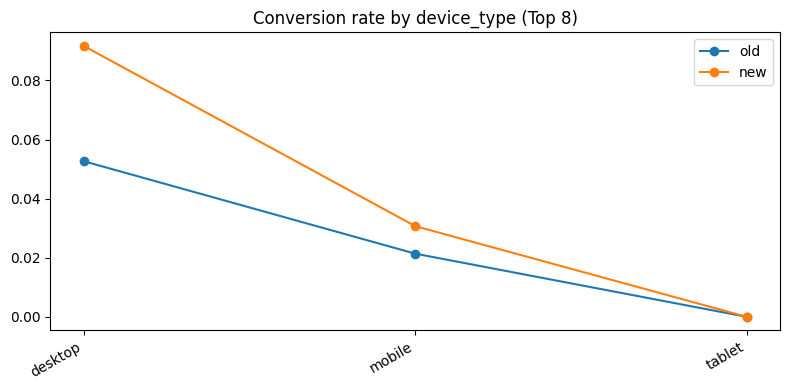

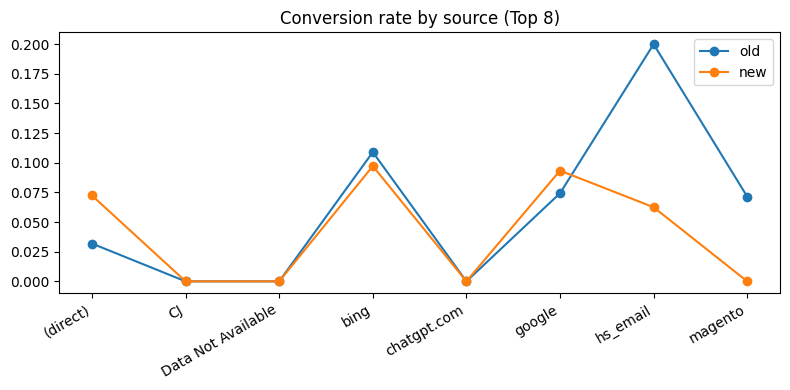

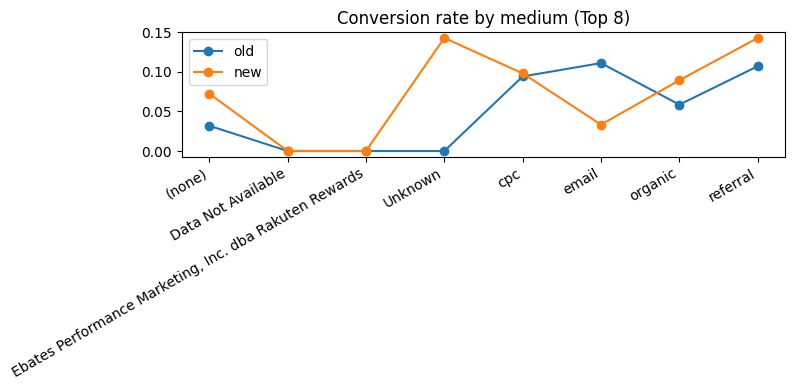

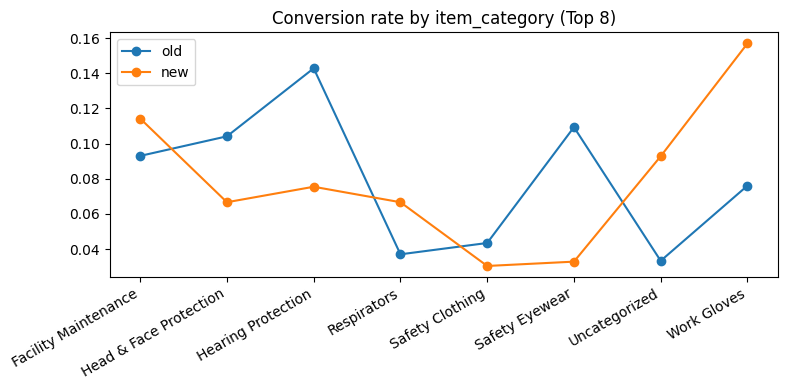


[cohort Metrics Summary + Differences]


,sessions,users,conv_rate,cart_value_mean,cart_value_median,time_on_site_mean,max_stage_mean
cohort,,,,,,,
new,"1,476.0000","1,386.0000",0.0820,786.3731,306.8500,"2,451.1883",4.2812
old,"2,087.0000","1,992.0000",0.0498,"1,520.7225",225.1000,"2,051.7489",3.6885
delta(new-old),-611.0000,-606.0000,0.0321,-734.3494,81.7500,399.4394,0.5926


In [17]:
# --- 0) PREPARE ---
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency
import matplotlib.pyplot as plt

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

# Quickly view the basic situation
print("Rows:", len(df), " | Cohorts:", df['cohort'].unique())

# --- 1) Light cleaning ---
# Discard completely missing promotion_name
if 'promotion_name' in df.columns:
    if df['promotion_name'].isna().all():
        df = df.drop(columns=['promotion_name'])

# Fill the value column (increase or decrease as needed)
num_cols = [c for c in ['cart_value', 'cart_quantity', 'time_on_site', 'max_stage']
            if c in df.columns]
for c in num_cols:
    fill_val = 0 if c in ['cart_value', 'cart_quantity'] else df[c].median()
    df[c] = df[c].fillna(fill_val)

# Category column filling (increase or decrease as needed)
cat_cols = [c for c in [
    'device_type','source','medium','item_category','browser','geo_country','item_name'
] if c in df.columns]
for c in cat_cols:
    df[c] = df[c].fillna('Unknown')

# Ensure labels are int/bool
if 'converted_within_7d' in df.columns:
    df['converted_within_7d'] = df['converted_within_7d'].astype(int)

# --- 2) Core indicators (cohort level) ---
agg_map = {
    'user_session_id': 'nunique',
    'user_pseudo_id': 'nunique',
    'converted_within_7d': 'mean'
}
if 'cart_value' in df.columns:
    agg_map['cart_value'] = ['mean','median']
if 'time_on_site' in df.columns:
    agg_map['time_on_site'] = 'mean'
if 'max_stage' in df.columns:
    agg_map['max_stage'] = 'mean'

summary = df.groupby('cohort').agg(agg_map)
# Flatten column names
summary.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in summary.columns]
summary = summary.rename(columns={
    'user_session_id_nunique':'sessions',
    'user_pseudo_id_nunique':'users',
    'converted_within_7d_mean':'conv_rate'
})
summary = summary.sort_index()
display(summary)

# --- 3) Significance of numerical features (old vs new) ---
def cohort_split(series):
    a = series[df['cohort']=='old'].dropna()
    b = series[df['cohort']=='new'].dropna()
    return a, b

num_tests = []
for c in num_cols:
    a, b = cohort_split(df[c])
    if len(a) > 2 and len(b) > 2:
        stat, p = ttest_ind(a, b, equal_var=False)
        num_tests.append([c, a.mean(), b.mean(), p])
num_tests = pd.DataFrame(num_tests, columns=['feature','old_mean','new_mean','p_value']).sort_values('p_value')
print("\n[Numerical feature t-test (the smaller the more significant)]")
display(num_tests)

# --- 4) Category Dimension: Distribution & Conversion Rate Difference ---
def rate_table(col, top_n=12, min_count=30):
    # Distribution (by cohort)
    cnt = (df.groupby(['cohort', col])['user_session_id']
             .nunique()
             .rename('sessions')
             .reset_index())
    # Conversion rate
    if 'converted_within_7d' in df.columns:
        conv = (df.groupby(['cohort', col])['converted_within_7d']
                 .mean()
                 .rename('conv_rate')
                 .reset_index())
        out = cnt.merge(conv, on=['cohort', col], how='left')
    else:
        out = cnt
    # Only keep the categories with the top N occurrences to avoid tail noise
    overall = df[col].value_counts().head(top_n).index
    out = out[out[col].isin(overall)]
    # Also filter low frequencies
    totals = out.groupby(col)['sessions'].sum()
    keep = totals[totals >= min_count].index
    out = out[out[col].isin(keep)]
    # Transparent for easy viewing
    piv_cnt  = out.pivot(index=col, columns='cohort', values='sessions').fillna(0).astype(int)
    if 'conv_rate' in out.columns:
        piv_conv = out.pivot(index=col, columns='cohort', values='conv_rate')
        # Add difference column
        if {'old','new'}.issubset(piv_conv.columns):
            piv_conv['delta_new_minus_old'] = piv_conv['new'] - piv_conv['old']
        return piv_cnt.sort_values(by=piv_cnt.columns.tolist(), ascending=False), \
               piv_conv.sort_values(by='delta_new_minus_old', ascending=False)
    return piv_cnt, None

for col in ['device_type', 'source', 'medium', 'item_category']:
    if col in df.columns:
        print(f"\n==== {col} ====")
        cnt_tbl, conv_tbl = rate_table(col, top_n=12, min_count=20)
        print("[Distribution(Number of Sessions)]")
        display(cnt_tbl)
        if conv_tbl is not None:
            print("[Conversion rate differences]")
            display(conv_tbl)

# --- 5) Category feature significance (Chi-square test, example: device_type) ---
chi_results = []
for col in ['device_type', 'source', 'medium', 'item_category']:
    if col in df.columns:
        ct = pd.crosstab(df[col], df['cohort'])
        if ct.shape[0] > 1 and ct.min().min() > 0:  # Avoid all 0s
            chi2, p, dof, ex = chi2_contingency(ct)
            chi_results.append([col, chi2, p, dof])
chi_results = pd.DataFrame(chi_results, columns=['feature','chi2','p_value','dof']).sort_values('p_value')
print("\n[Category characteristics Chi-square test (the smaller the more significant)]")
display(chi_results)

# --- 6) Fast plotting (matplotlib, avoid specifying colors for compatibility)---
def bar_conv(col):
    tmp = (df.groupby(['cohort', col])['converted_within_7d']
             .mean()
             .reset_index())
    top = df[col].value_counts().head(8).index
    tmp = tmp[tmp[col].isin(top)]
    fig = plt.figure(figsize=(8,4))
    for cohort in ['old','new']:
        sub = tmp[tmp['cohort']==cohort]
        plt.plot(sub[col].astype(str), sub['converted_within_7d'], marker='o', label=cohort)
    plt.title(f'Conversion rate by {col} (Top 8)')
    plt.xticks(rotation=30, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

if 'converted_within_7d' in df.columns:
    for col in ['device_type','source','medium','item_category']:
        if col in df.columns:
            bar_conv(col)

# --- 7) See the "Summary" of the differences at a glance ---
summary_out = summary.copy()
if {'old','new'}.issubset(summary_out.index):
    summary_out.loc['delta(new-old)'] = summary_out.loc['new'] - summary_out.loc['old']
print("\n[cohort Metrics Summary + Differences]")
display(summary_out)


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 0) Data preparation & light cleaning
# -----------------------------
df = df.copy()
assert {'cohort','cart_value','converted_within_7d','item_category','user_session_id','user_pseudo_id'}.issubset(df.columns)
df['cart_value'] = df['cart_value'].fillna(0.0)
df['converted_within_7d'] = df['converted_within_7d'].fillna(0).astype(int)
df['item_category'] = df['item_category'].fillna('Uncategorized')
if 'device_type' not in df.columns:
    df['device_type'] = 'Unknown'

# -----------------------------
# 1) Basic summary: retain original metrics + efficiency metrics
# -----------------------------
cohort_base = (
    df.groupby('cohort', as_index=True)
      .agg(
          sessions=('user_session_id','nunique'),
          users=('user_pseudo_id','nunique'),
          conv_rate=('converted_within_7d','mean'),
          cart_value_sum=('cart_value','sum'),
          cart_value_mean=('cart_value','mean'),
          cart_value_median=('cart_value','median')
      )
)

# Observed GMV (sum of cart_value for converted sessions)
cohort_base['gmv_proxy_observed'] = (
    df.assign(_gmv=df['cart_value'] * df['converted_within_7d'])
      .groupby('cohort')['_gmv'].sum()
)

# Expected GMV (global conversion rate × total cart_value)
cohort_base['gmv_expected_global'] = cohort_base['conv_rate'] * cohort_base['cart_value_sum']

# —— Efficiency metrics (scale-independent)
cohort_base['gmv_per_user_observed']   = cohort_base['gmv_proxy_observed']   / cohort_base['users'].clip(lower=1)
cohort_base['gmv_per_session_observed']= cohort_base['gmv_proxy_observed']   / cohort_base['sessions'].clip(lower=1)
cohort_base['gmv_per_user_expected']   = cohort_base['gmv_expected_global']  / cohort_base['users'].clip(lower=1)
cohort_base['gmv_per_session_expected']= cohort_base['gmv_expected_global']  / cohort_base['sessions'].clip(lower=1)

print("\n=== Cohort overview (with efficiency metrics) ===")
display(cohort_base)

# -----------------------------
# 2) Scale normalization: align GMV to the same user/session size
#    Idea: apply each cohort’s efficiency (per-user / per-session) × same scale
# -----------------------------
target_users    = cohort_base['users'].min()       # Align to the smaller user count
target_sessions = cohort_base['sessions'].min()    # Align to the smaller session count

scale_norm = pd.DataFrame(index=cohort_base.index)
scale_norm['gmv_users_normalized_observed']   = cohort_base['gmv_per_user_observed']   * target_users
scale_norm['gmv_sessions_normalized_observed']= cohort_base['gmv_per_session_observed']* target_sessions
scale_norm['gmv_users_normalized_expected']   = cohort_base['gmv_per_user_expected']   * target_users
scale_norm['gmv_sessions_normalized_expected']= cohort_base['gmv_per_session_expected']* target_sessions

print("\n=== Scale-normalized GMV (aligned users/sessions) ===")
display(scale_norm)

# -----------------------------
# 3) Structural standardization (remove mix shift effects)
#    Use "old cohort" structure as weights, apply to new cohort efficiency (conversion & AOV)
#    Structure dimensions: item_category × device_type (can extend to source/medium if needed)
# -----------------------------
# 3.1 Old cohort structure weights (by session share, could also use user share)
old_mask = (df['cohort']=='old')
strata_cols = ['item_category','device_type']
old_strata = (
    df[old_mask].groupby(strata_cols)
      .agg(sessions=('user_session_id','nunique'),
           users=('user_pseudo_id','nunique'),
           cart_sum=('cart_value','sum'),
           conv=('converted_within_7d','mean'))
      .reset_index()
)
old_total_sessions = max(old_strata['sessions'].sum(), 1)
old_strata['w_sessions'] = old_strata['sessions'] / old_total_sessions  # weights

# 3.2 Compute efficiency for old/new in each stratum: conv rate & AOV
def strata_eff(df_subset):
    g = (df_subset.groupby(strata_cols)
         .agg(
             sessions=('user_session_id','nunique'),
             cart_sum=('cart_value','sum'),
             conv=('converted_within_7d','mean')
         ).reset_index())
    g['AOV'] = g['cart_sum'] / g['sessions'].replace(0, np.nan)
    return g.fillna(0)

eff_old = strata_eff(df[df['cohort']=='old'])
eff_new = strata_eff(df[df['cohort']=='new'])

# 3.3 Merge efficiency with "old structure weights"
eff_old_w = old_strata[strata_cols + ['w_sessions']].merge(eff_old, on=strata_cols, how='left', suffixes=('',''))
eff_new_w = old_strata[strata_cols + ['w_sessions']].merge(eff_new, on=strata_cols, how='left', suffixes=('',''))

# 3.4 Standardized GMV per session (expected)
#     Purpose: not restoring absolute GMV, but comparing efficiency after removing structure difference
def standardize_expected_per_session(eff_w):
    # Expected GMV/session = conv × AOV
    eff_w = eff_w.copy()
    eff_w['exp_gmv_per_session'] = eff_w['conv'] * eff_w['AOV']
    # Weighted average using "old structure weights"
    return (eff_w['exp_gmv_per_session'] * eff_w['w_sessions']).sum()

std_old_per_session = standardize_expected_per_session(eff_old_w)
std_new_per_session = standardize_expected_per_session(eff_new_w)

std_table = pd.DataFrame({
    'std_exp_gmv_per_session': {
        'old': std_old_per_session,
        'new': std_new_per_session
    }
})

print("\n=== Structure-standardized expected GMV per session (using OLD structure weights) ===")
display(std_table)

# 3.5 Optional: per-user standardization (if you prefer per-user efficiency)
def standardize_expected_per_user(eff_w):
    eff_w = eff_w.copy()
    if 'users' not in eff_w.columns:
        eff_w['users'] = eff_w['sessions']
    eff_w['AOV_per_user_approx'] = eff_w['cart_sum'] / eff_w['users'].replace(0, np.nan)
    eff_w['exp_gmv_per_user'] = eff_w['conv'] * eff_w['AOV_per_user_approx']
    return (eff_w['exp_gmv_per_user'] * eff_w['w_sessions']).sum()

try:
    std_old_per_user = standardize_expected_per_user(eff_old_w)
    std_new_per_user = standardize_expected_per_user(eff_new_w)
    std_table_user = pd.DataFrame({
        'std_exp_gmv_per_user_approx': {
            'old': std_old_per_user,
            'new': std_new_per_user
        }
    })
    print("\n=== Structure-standardized expected GMV per user (approx, using OLD structure weights) ===")
    display(std_table_user)
except Exception as e:
    print("Per-user standardization skipped (need reliable users per stratum).", e)

# -----------------------------
# 4) Interpretation tips (optional print)
# -----------------------------
print("""
Interpretation tips:
- Use 'gmv_per_user/session' to compare efficiency without being biased by traffic scale.
- Use '..._normalized_' metrics to answer: if both periods had the same number of users/sessions, who would win?
- Use 'Structure-standardized ...' to answer: removing mix shifts (category×device), which period is intrinsically stronger?
""")

# -----------------------------
# 5) Category-level GMV contribution analysis
#    Can be combined with standardized results
# -----------------------------
cat_proxy = (df.assign(_gmv=df['cart_value']*df['converted_within_7d'])
               .groupby(['cohort','item_category'])
               .agg(cat_sessions=('user_session_id','nunique'),
                    cat_conv=('converted_within_7d','mean'),
                    cat_cart_sum=('cart_value','sum'),
                    gmv_proxy_observed=('_gmv','sum'))
               .reset_index())
cat_proxy['gmv_expected_local'] = cat_proxy['cat_conv'] * cat_proxy['cat_cart_sum']

# Map total cohort GMV for share calculation
cohort_proxy_dict = cohort_base['gmv_proxy_observed'].to_dict()
cohort_expected_dict = cohort_base['gmv_expected_global'].to_dict()
cat_proxy['cohort_gmv_proxy_observed'] = cat_proxy['cohort'].map(cohort_proxy_dict)
cat_proxy['cohort_gmv_expected_global'] = cat_proxy['cohort'].map(cohort_expected_dict)
cat_proxy['share_proxy_observed'] = cat_proxy['gmv_proxy_observed'] / cat_proxy['cohort_gmv_proxy_observed']
cat_proxy['share_expected_global'] = cat_proxy['gmv_expected_local'] / cat_proxy['cohort_gmv_expected_global']

print("\n=== Category contributions (proxy & expected) ===")
display(cat_proxy.head(12))



=== Cohort overview (with efficiency metrics) ===


,sessions,users,conv_rate,cart_value_sum,cart_value_mean,cart_value_median,gmv_proxy_observed,gmv_expected_global,gmv_per_user_observed,gmv_per_session_observed,gmv_per_user_expected,gmv_per_session_expected
cohort,,,,,,,,,,,,
new,1476,1386,0.0820,"1,160,686.6796",786.3731,306.8500,"134,035.3200","95,151.1438",96.7066,90.8098,68.6516,64.4655
old,2087,1992,0.0498,"3,173,747.8278","1,520.7225",225.1000,"231,958.7895","158,155.1385",116.4452,111.1446,79.3951,75.7811



=== Scale-normalized GMV (aligned users/sessions) ===


,gmv_users_normalized_observed,gmv_sessions_normalized_observed,gmv_users_normalized_expected,gmv_sessions_normalized_expected
cohort,,,,
new,"134,035.3200","134,035.3200","95,151.1438","95,151.1438"
old,"161,393.0131","164,049.4361","110,041.6777","111,852.8915"



=== Structure-standardized expected GMV per session (using OLD structure weights) ===


,std_exp_gmv_per_session
old,74.7314
new,92.5046



=== Structure-standardized expected GMV per user (approx, using OLD structure weights) ===


,std_exp_gmv_per_user_approx
old,74.7314
new,92.5046



Interpretation tips:
- Use 'gmv_per_user/session' to compare efficiency without being biased by traffic scale.
- Use '..._normalized_' metrics to answer: if both periods had the same number of users/sessions, who would win?
- Use 'Structure-standardized ...' to answer: removing mix shifts (category×device), which period is intrinsically stronger?


=== Category contributions (proxy & expected) ===


,cohort,item_category,cat_sessions,cat_conv,cat_cart_sum,gmv_proxy_observed,gmv_expected_local,cohort_gmv_proxy_observed,cohort_gmv_expected_global,share_proxy_observed,share_expected_global
0,new,Coated Gloves,1,0.0000,193.1900,0.0000,0.0000,"134,035.3200","95,151.1438",0.0000,0.0000
1,new,Cooling Products,3,0.0000,181.9000,0.0000,0.0000,"134,035.3200","95,151.1438",0.0000,0.0000
2,new,Emergency Response,19,0.0526,"72,957.0500",190.5000,"3,839.8447","134,035.3200","95,151.1438",0.0014,0.0404
3,new,Ergonomic Products,9,0.0000,603.3000,0.0000,0.0000,"134,035.3200","95,151.1438",0.0000,0.0000
4,new,Facility Maintenance,35,0.1143,"102,709.4099","3,487.6300","11,738.2183","134,035.3200","95,151.1438",0.0260,0.1234
5,new,Fall Protection,9,0.1111,"31,012.4500","1,061.2500","3,445.8278","134,035.3200","95,151.1438",0.0079,0.0362
6,new,First Aid,7,0.1429,"1,126.6400",454.9300,160.9486,"134,035.3200","95,151.1438",0.0034,0.0017
7,new,Head & Face Protection,30,0.0667,"14,148.3600","1,163.4900",943.2240,"134,035.3200","95,151.1438",0.0087,0.0099
8,new,Hearing Protection,53,0.0755,"34,316.4000","4,696.2300","2,589.9170","134,035.3200","95,151.1438",0.0350,0.0272
9,new,Leather Work Gloves,3,0.0000,"2,472.8300",0.0000,0.0000,"134,035.3200","95,151.1438",0.0000,0.0000



=== Cohort overview (with GMV metrics) ===


,sessions,users,conv_rate,cart_value_sum,cart_value_mean,cart_value_median,gmv_proxy_observed,gmv_expected_global,gmv_expected_by_category
cohort,,,,,,,,,
new,1476,1386,0.0820,"1,160,686.6796",786.3731,306.8500,"134,035.3200","95,151.1438","105,532.7492"
old,2087,1992,0.0498,"3,173,747.8278","1,520.7225",225.1000,"231,958.7895","158,155.1385","152,248.6890"



=== Category-level GMV contributions (Observed & Expected) ===


,cohort,item_category,cat_sessions,cat_conv,cat_cart_sum,gmv_proxy_observed,gmv_expected_local,cohort_gmv_proxy_observed,cohort_gmv_expected_by_cat,share_proxy_observed,share_expected_local
0,new,Coated Gloves,1,0.0000,193.1900,0.0000,0.0000,"134,035.3200","105,532.7492",0.0000,0.0000
1,new,Cooling Products,3,0.0000,181.9000,0.0000,0.0000,"134,035.3200","105,532.7492",0.0000,0.0000
2,new,Emergency Response,19,0.0526,"72,957.0500",190.5000,"3,839.8447","134,035.3200","105,532.7492",0.0014,0.0364
3,new,Ergonomic Products,9,0.0000,603.3000,0.0000,0.0000,"134,035.3200","105,532.7492",0.0000,0.0000
4,new,Facility Maintenance,35,0.1143,"102,709.4099","3,487.6300","11,738.2183","134,035.3200","105,532.7492",0.0260,0.1112
5,new,Fall Protection,9,0.1111,"31,012.4500","1,061.2500","3,445.8278","134,035.3200","105,532.7492",0.0079,0.0327
6,new,First Aid,7,0.1429,"1,126.6400",454.9300,160.9486,"134,035.3200","105,532.7492",0.0034,0.0015
7,new,Head & Face Protection,30,0.0667,"14,148.3600","1,163.4900",943.2240,"134,035.3200","105,532.7492",0.0087,0.0089
8,new,Hearing Protection,53,0.0755,"34,316.4000","4,696.2300","2,589.9170","134,035.3200","105,532.7492",0.0350,0.0245
9,new,Leather Work Gloves,3,0.0000,"2,472.8300",0.0000,0.0000,"134,035.3200","105,532.7492",0.0000,0.0000



=== Category-level: GMV contribution increase TOP10 (new - old) ===


,delta_gmv_proxy_observed,delta_gmv_expected_local
item_category,,
Fall Protection,"1,061.2500","3,445.8278"
Respirators,608.1400,473.9761
Ergonomic Products,0.0000,0.0000
Leather Work Gloves,0.0000,0.0000
Coated Gloves,0.0000,0.0000
Cooling Products,-797.4000,"-1,163.2500"
Emergency Response,"-1,023.0000","2,335.0593"
Safety Eyewear,"-1,058.3100",NaN
First Aid,"-2,755.1200","-1,626.4014"



=== Category-level: GMV contribution decrease TOP10 (new - old) ===


,delta_gmv_proxy_observed,delta_gmv_expected_local
item_category,,
Gas Detection,NaN,NaN
Heat & Flame Resistant Clothing,NaN,NaN
Heat Stress Clothing,NaN,NaN
Impact Gloves,NaN,NaN
Miscellaneous,NaN,NaN
Other Safety,NaN,NaN
Safety Glasses,NaN,NaN
Safety Goggles,NaN,NaN
"Safety Lens, Glasses Cleaners & Wipes",NaN,NaN


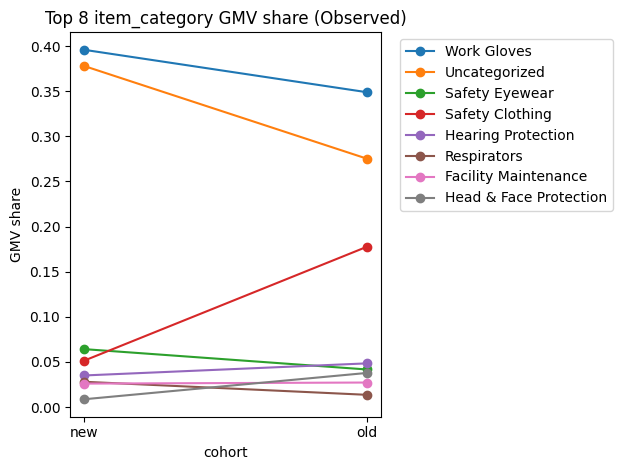

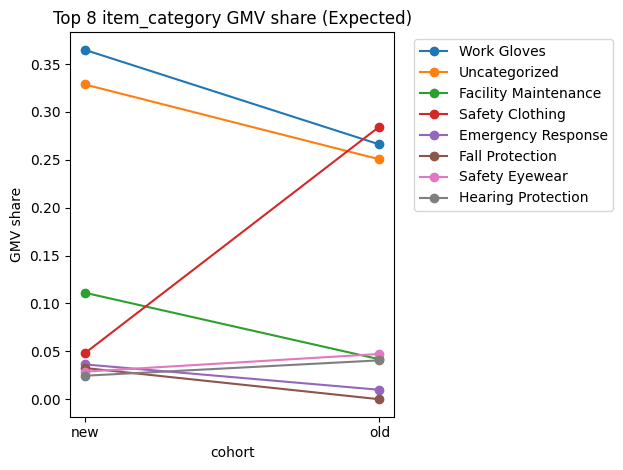

Saved: cohort_gmv_overview.csv, cohort_item_category_gmv_breakdown.csv, cohort_item_category_new_vs_old_wide.csv


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------- 0) Light cleaning (ensure columns exist & handle missing values) --------
df = df.copy()
assert {'cohort','cart_value','converted_within_7d','item_category'}.issubset(df.columns), "Missing required columns"

df['cart_value'] = df['cart_value'].fillna(0.0)
df['converted_within_7d'] = df['converted_within_7d'].fillna(0).astype(int)
df['item_category'] = df['item_category'].fillna('Uncategorized')

# -------- 1) Cohort-level GMV summary --------
cohort_base = (
    df.groupby('cohort', as_index=True)
      .agg(sessions=('user_session_id','nunique'),
           users=('user_pseudo_id','nunique'),
           conv_rate=('converted_within_7d','mean'),
           cart_value_sum=('cart_value','sum'),
           cart_value_mean=('cart_value','mean'),
           cart_value_median=('cart_value','median'))
)

# Observed GMV (sum of converted cart_value)
cohort_base['gmv_proxy_observed'] = (
    df.assign(_gmv=df['cart_value']*df['converted_within_7d'])
      .groupby('cohort')['_gmv'].sum()
)

# Expected GMV (global conv_rate × total cart_value)
cohort_base['gmv_expected_global'] = cohort_base['conv_rate'] * cohort_base['cart_value_sum']

# Expected GMV (category-level: cat_conv_rate × cat_cart_sum, then aggregated)
cat_stats = (df.groupby(['cohort','item_category'])
               .agg(cat_sessions=('user_session_id','nunique'),
                    cat_conv=('converted_within_7d','mean'),
                    cat_cart_sum=('cart_value','sum'))
               .reset_index())

cohort_expected_by_cat = (
    cat_stats.assign(exp_gmv=lambda x: x['cat_conv'] * x['cat_cart_sum'])
             .groupby('cohort')['exp_gmv'].sum()
)
cohort_base['gmv_expected_by_category'] = cohort_expected_by_cat

print("\n=== Cohort overview (with GMV metrics) ===")
display(cohort_base)

# -------- 2) Category-level GMV contribution table (two approaches) --------
# Observed: sum(cart_value * converted)
cat_proxy = (df.assign(_gmv=df['cart_value']*df['converted_within_7d'])
               .groupby(['cohort','item_category'])
               .agg(cat_sessions=('user_session_id','nunique'),
                    cat_conv=('converted_within_7d','mean'),
                    cat_cart_sum=('cart_value','sum'),
                    gmv_proxy_observed=('_gmv','sum'))
               .reset_index())

# Expected (category-local)
cat_proxy['gmv_expected_local'] = cat_proxy['cat_conv'] * cat_proxy['cat_cart_sum']

# --- Fix: use dict mapping for cohort GMV to avoid messy merge column names ---
cohort_proxy_dict = cohort_base['gmv_proxy_observed'].to_dict()
cohort_expected_dict = cohort_base['gmv_expected_by_category'].to_dict()

cat_proxy['cohort_gmv_proxy_observed'] = cat_proxy['cohort'].map(cohort_proxy_dict)
cat_proxy['cohort_gmv_expected_by_cat'] = cat_proxy['cohort'].map(cohort_expected_dict)

# Share of cohort GMV
cat_proxy['share_proxy_observed'] = cat_proxy['gmv_proxy_observed'] / cat_proxy['cohort_gmv_proxy_observed']
cat_proxy['share_expected_local'] = cat_proxy['gmv_expected_local'] / cat_proxy['cohort_gmv_expected_by_cat']

print("\n=== Category-level GMV contributions (Observed & Expected) ===")
display(cat_proxy.head(12))

# -------- 3) Category-level new vs old comparison (differences, ranking) --------
# Pivot new/old to the same row for comparison
pivot_cols = ['cat_sessions','cat_conv','cat_cart_sum',
              'gmv_proxy_observed','gmv_expected_local',
              'share_proxy_observed','share_expected_local']
wide = (cat_proxy.pivot(index='item_category', columns='cohort', values=pivot_cols)
                 .sort_index(axis=1, level=0))

# Generate delta columns: new - old
for col in pivot_cols:
    if ('new' in wide[col].columns) and ('old' in wide[col].columns):
        wide[(col,'delta_new_minus_old')] = wide[(col,'new')] - wide[(col,'old')]

# Focus: GMV contribution changes (Observed & Expected)
rank_observed = (wide[('gmv_proxy_observed','delta_new_minus_old')]
                 .sort_values(ascending=False)
                 .rename('delta_gmv_proxy_observed'))
rank_expected = (wide[('gmv_expected_local','delta_new_minus_old')]
                 .sort_values(ascending=False)
                 .rename('delta_gmv_expected_local'))

top_gain = pd.concat([rank_observed.head(10), rank_expected.head(10)], axis=1)
top_drop = pd.concat([rank_observed.tail(10), rank_expected.tail(10)], axis=1)

print("\n=== Category-level: GMV contribution increase TOP10 (new - old) ===")
display(top_gain)

print("\n=== Category-level: GMV contribution decrease TOP10 (new - old) ===")
display(top_drop)

# -------- 4) Optional: visualization (GMV share changes for top categories) --------
def plot_share_change(top_k=8, mode='proxy'):
    col = 'share_proxy_observed' if mode=='proxy' else 'share_expected_local'
    # Select Top K categories by new cohort GMV share
    new_top = (cat_proxy[cat_proxy['cohort']=='new']
               .nlargest(top_k, col)['item_category'])
    sub = cat_proxy[cat_proxy['item_category'].isin(new_top)]
    # Plot line chart
    for cat in new_top:
        tmp = sub[sub['item_category']==cat]
        plt.plot(tmp['cohort'], tmp[col], marker='o', label=cat)
    plt.title(f"Top {top_k} item_category GMV share ({'Observed' if mode=='proxy' else 'Expected'})")
    plt.xlabel("cohort")
    plt.ylabel("GMV share")
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Observed
plot_share_change(top_k=8, mode='proxy')
# Expected
plot_share_change(top_k=8, mode='expected')

# -------- 5) Export results (optional) --------
cohort_base.to_csv("cohort_gmv_overview.csv")
cat_proxy.to_csv("cohort_item_category_gmv_breakdown.csv", index=False)
wide.to_csv("cohort_item_category_new_vs_old_wide.csv")
print("Saved: cohort_gmv_overview.csv, cohort_item_category_gmv_breakdown.csv, cohort_item_category_new_vs_old_wide.csv")


In [20]:
import pandas as pd
import numpy as np

def gmv_decomposition_by_category(
    df,
    cohort_col='cohort',
    category_col='item_category',
    session_col='user_session_id',
    conv_col='converted_within_7d',
    value_col='cart_value'
):
    # 1) Preprocessing
    data = df[[cohort_col, category_col, session_col, conv_col, value_col]].copy()
    data[conv_col] = data[conv_col].fillna(0).astype(float)
    data[value_col] = data[value_col].fillna(0.0)
    data[category_col] = data[category_col].fillna('Uncategorized')

    # 2) Aggregate N, p, m for each cohort × category
    agg = (data
           .groupby([cohort_col, category_col])
           .agg(N=(session_col, 'nunique'),
                p=(conv_col, 'mean'),
                m=(value_col, 'mean'))
           .reset_index())

    # 3) Ensure all categories exist in both old/new cohorts
    cats = agg[category_col].unique()
    cohorts = ['old','new']
    full = (pd.MultiIndex.from_product([cohorts, cats], names=[cohort_col, category_col])
              .to_frame(index=False)
              .merge(agg, on=[cohort_col, category_col], how='left')
              .fillna({'N':0,'p':0.0,'m':0.0}))

    # 4) Wide table: each category as row, old/new columns for N, p, m
    wide = (full.pivot(index=category_col, columns=cohort_col, values=['N','p','m'])
                 .sort_index())
    # Fill missing cohorts with 0
    for var in ['N','p','m']:
        if 'old' not in wide[var].columns: wide[var,'old'] = 0.0
        if 'new' not in wide[var].columns: wide[var,'new'] = 0.0
    wide = wide.sort_index(axis=1, level=0)

    # 5) Compute GMV (expected = N × p × m) and Shapley decomposition
    No, Po, Mo = wide[('N','old')], wide[('p','old')], wide[('m','old')]
    Nn, Pn, Mn = wide[('N','new')], wide[('p','new')], wide[('m','new')]

    GMV_old = No * Po * Mo
    GMV_new = Nn * Pn * Mn
    dGMV    = GMV_new - GMV_old

    # Shapley contributions
    Delta_N = (Nn - No) * ( (Po*Mo + Pn*Mo + Pn*Mn + Po*Mn) / 4.0 )
    Delta_p = (Pn - Po) * ( (No*Mo + Nn*Mo + Nn*Mn + No*Mn) / 4.0 )
    Delta_m = (Mn - Mo) * ( (No*Po + Nn*Po + Nn*Pn + No*Pn) / 4.0 )

    # 6) Assemble output
    out = pd.DataFrame({
        category_col: wide.index,
        'N_old': No, 'p_old': Po, 'm_old': Mo, 'GMV_old': GMV_old,
        'N_new': Nn, 'p_new': Pn, 'm_new': Mn, 'GMV_new': GMV_new,
        'delta_GMV': dGMV,
        'contrib_N': Delta_N,
        'contrib_p': Delta_p,
        'contrib_m': Delta_m
    }).reset_index(drop=True)

    # Residual check (numerical error tolerance)
    out['residual'] = out['delta_GMV'] - (out['contrib_N'] + out['contrib_p'] + out['contrib_m'])

    # Contribution shares (avoid division by zero)
    out['share_N'] = out['contrib_N'] / (out['delta_GMV'].replace(0, np.nan))
    out['share_p'] = out['contrib_p'] / (out['delta_GMV'].replace(0, np.nan))
    out['share_m'] = out['contrib_m'] / (out['delta_GMV'].replace(0, np.nan))

    # Sort by absolute GMV change
    out = out.sort_values('delta_GMV', ascending=False).reset_index(drop=True)
    return out

# —— Run decomposition ——
decomp = gmv_decomposition_by_category(df)
print("=== GMV Decomposition by Category ===")
display(decomp.head(15))

# Top gain/loss categories
top_up   = decomp.nlargest(10, 'delta_GMV')[['item_category','delta_GMV','contrib_N','contrib_p','contrib_m','share_N','share_p','share_m']]
top_down = decomp.nsmallest(10, 'delta_GMV')[['item_category','delta_GMV','contrib_N','contrib_p','contrib_m','share_N','share_p','share_m']]

print("\n=== GMV Increase TOP10: Which factors drove growth? ===")
display(top_up)
print("\n=== GMV Decrease TOP10: Which factors dragged performance? ===")
display(top_down)

# Optional: export results
decomp.to_csv("gmv_decomposition_by_category.csv", index=False)
print("Saved: gmv_decomposition_by_category.csv")


=== GMV Decomposition by Category ===


,item_category,N_old,p_old,m_old,GMV_old,N_new,p_new,m_new,GMV_new,delta_GMV,contrib_N,contrib_p,contrib_m,residual,share_N,share_p,share_m
0,Facility Maintenance,43.0000,0.0930,"1,588.0286","6,352.1144",35.0000,0.1143,"2,934.5546","11,738.2183","5,386.1039","-1,875.1441","1,875.1441","5,443.3648",-57.2609,-0.3481,0.3481,1.0106
1,Fall Protection,15.0000,0.0000,"5,889.3120",0.0000,9.0000,0.1111,"3,445.8278","3,445.8278","3,445.8278","-1,555.8566","6,223.4265","-1,628.9895",407.2474,-0.4515,1.8061,-0.4727
2,Emergency Response,46.0000,0.0217,"1,504.7854","1,504.7854",19.0000,0.0526,"3,839.8447","3,839.8447","2,335.0593","-2,683.0166","2,683.0166","2,821.9753",-486.9160,-1.1490,1.1490,1.2085
3,Respirators,81.0000,0.0370,345.8909,"1,037.6726",30.0000,0.0667,755.8243,"1,511.6487",473.9761,"-1,456.7123",905.8547,"1,179.6974",-154.8638,-3.0734,1.9112,2.4889
4,Disposable Respirators,1.0000,0.0000,212.2000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,NaN,NaN,NaN
5,Disposable Gloves,1.0000,0.0000,132.0500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,NaN,NaN,NaN
6,Coated Gloves,1.0000,0.0000,172.3600,0.0000,1.0000,0.0000,193.1900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN
7,Eyes & Ears,69.0000,0.0000,207.4257,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,NaN,NaN,NaN
8,Gas Detection,1.0000,0.0000,872.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,NaN,NaN,NaN
9,Earplugs,3.0000,0.0000,248.9600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,NaN,NaN,NaN



=== GMV Increase TOP10: Which factors drove growth? ===


,item_category,delta_GMV,contrib_N,contrib_p,contrib_m,share_N,share_p,share_m
0,Facility Maintenance,"5,386.1039","-1,875.1441","1,875.1441","5,443.3648",-0.3481,0.3481,1.0106
1,Fall Protection,"3,445.8278","-1,555.8566","6,223.4265","-1,628.9895",-0.4515,1.8061,-0.4727
2,Emergency Response,"2,335.0593","-2,683.0166","2,683.0166","2,821.9753",-1.1490,1.1490,1.2085
3,Respirators,473.9761,"-1,456.7123",905.8547,"1,179.6974",-3.0734,1.9112,2.4889
4,Disposable Respirators,0.0000,-0.0000,0.0000,-0.0000,NaN,NaN,NaN
5,Disposable Gloves,0.0000,-0.0000,0.0000,-0.0000,NaN,NaN,NaN
6,Coated Gloves,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN
7,Eyes & Ears,0.0000,-0.0000,0.0000,-0.0000,NaN,NaN,NaN
8,Gas Detection,0.0000,-0.0000,0.0000,-0.0000,NaN,NaN,NaN
9,Earplugs,0.0000,-0.0000,0.0000,-0.0000,NaN,NaN,NaN



=== GMV Decrease TOP10: Which factors dragged performance? ===


,item_category,delta_GMV,contrib_N,contrib_p,contrib_m,share_N,share_p,share_m
30,Safety Clothing,"-38,287.1399",-215.9504,"-7,578.2976","-30,465.7127",0.0056,0.1979,0.7957
29,Safety Eyewear,"-4,153.4418","7,752.9769","-7,752.9769","-5,844.5099",-1.8666,1.8666,1.4071
28,Hearing Protection,"-3,596.1016","1,007.7680","-2,686.2504","-1,988.6900",-0.2802,0.7470,0.5530
27,Uncategorized,"-3,457.4625","-30,357.3648","42,240.0940","-18,258.2518",8.7802,-12.2171,5.2808
26,Head & Face Protection,"-2,448.3322",-884.0035,-840.8814,-688.5669,0.3611,0.3435,0.2812
25,Work Gloves,"-1,999.3073","-9,980.7311","30,534.5242","-23,477.8113",4.9921,-15.2726,11.7430
24,First Aid,"-1,626.4014",0.0000,0.0000,"-1,626.4014",-0.0000,-0.0000,1.0000
23,Impact Gloves,"-1,280.3000",-320.0750,-320.0750,-320.0750,0.2500,0.2500,0.2500
22,Cooling Products,"-1,163.2500",-214.1796,-397.7621,-358.3504,0.1841,0.3419,0.3081
21,Heat Stress Clothing,-193.8000,-48.4500,-48.4500,-48.4500,0.2500,0.2500,0.2500


Saved: gmv_decomposition_by_category.csv


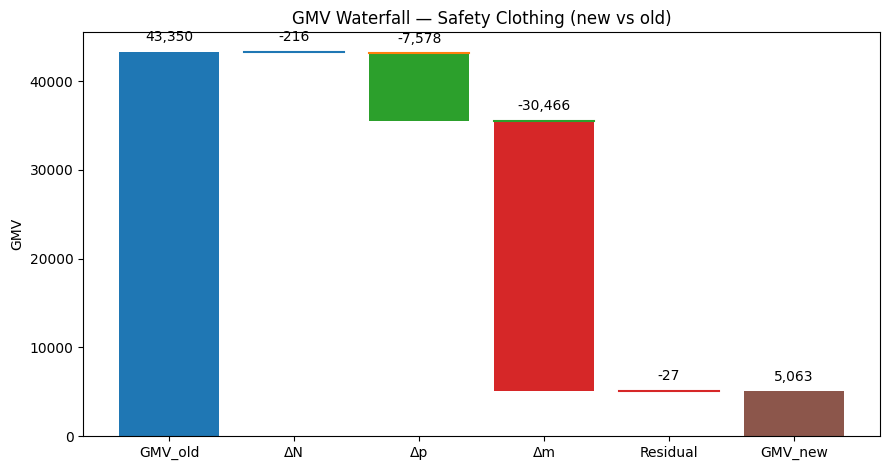

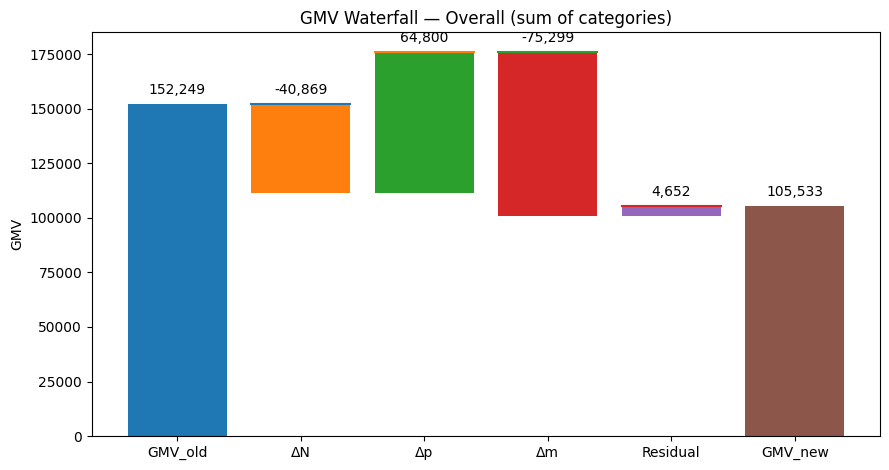

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_waterfall_from_row(row: pd.Series, title: str):
    """
    Render a GMV waterfall chart for a single category (or overall):
    GMV_old -> +ΔN -> +Δp -> +Δm -> +residual -> GMV_new
    """
    gmv_old = float(row['GMV_old'])
    contrib_N = float(row['contrib_N'])
    contrib_p = float(row['contrib_p'])
    contrib_m = float(row['contrib_m'])
    residual  = float(row.get('residual', 0.0))
    gmv_new   = float(row['GMV_new'])

    steps   = ['GMV_old','ΔN','Δp','Δm','Residual','GMV_new']
    deltas  = [gmv_old, contrib_N, contrib_p, contrib_m, residual,
               gmv_new - (gmv_old + contrib_N + contrib_p + contrib_m + residual)]

    # Compute the base (bottom) and height for each bar
    bottoms, heights = [], []
    running = 0.0
    for i, amt in enumerate(deltas):
        if i == 0:  # GMV_old
            bottoms.append(0.0); heights.append(amt); running += amt
        elif i < len(deltas)-1:  # intermediate incremental contributions
            if amt >= 0:
                bottoms.append(running); heights.append(amt); running += amt
            else:
                bottoms.append(running + amt); heights.append(-amt); running += amt
        else:  # final bar: plot GMV_new directly
            bottoms.append(0.0); heights.append(gmv_new)

    x = np.arange(len(steps))
    plt.figure(figsize=(9, 4.8))
    for i in range(len(steps)):
        plt.bar(x[i], heights[i], bottom=bottoms[i])
        # Add value labels
        val = deltas[i] if i != len(steps)-1 else gmv_new
        y_text = bottoms[i] + (heights[i] if heights[i] >= 0 else 0) + max(heights) * 0.02
        plt.text(x[i], y_text, f"{val:,.0f}", ha='center', va='bottom')

    # Connector lines (to improve readability)
    for i in range(1, len(steps)-1):
        y = bottoms[i] + heights[i]
        plt.plot([x[i]-0.4, x[i]+0.4], [y, y])

    plt.xticks(x, steps)
    plt.ylabel("GMV")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ====== Example Usage ======
# 1) Plot the category with the largest absolute GMV change
top_cat = decomp.loc[decomp['delta_GMV'].abs().idxmax(), 'item_category']
plot_waterfall_from_row(
    decomp[decomp['item_category'] == top_cat].iloc[0],
    f"GMV Waterfall — {top_cat} (new vs old)"
)

# 2) Plot the overall waterfall chart (sum across all categories)
totals = pd.Series({
    'GMV_old':   decomp['GMV_old'].sum(),
    'contrib_N': decomp['contrib_N'].sum(),
    'contrib_p': decomp['contrib_p'].sum(),
    'contrib_m': decomp['contrib_m'].sum(),
    'residual':  decomp['residual'].sum(),
    'GMV_new':   decomp['GMV_new'].sum(),
})
plot_waterfall_from_row(totals, "GMV Waterfall — Overall (sum of categories)")
